In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install transformers
!pip install stop_words
!pip install symspellpy
!pip install language_detector 
!pip install cached_property
!pip install sentencepiece
!pip install config

     |████████████████████████████████| 2.5MB 5.2MB/s 
     |████████████████████████████████| 901kB 38.9MB/s 
     |████████████████████████████████| 3.3MB 37.6MB/s 
  Created wheel for stop-words: filename=stop_words-2018.7.23-cp37-none-any.whl size=32913 sha256=21301e546e2c7718fd007394d92de72c32e9be6f7593725d9494c95373442e82
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words
     |████████████████████████████████| 2.6MB 4.1MB/s 
  Created wheel for language-detector: filename=language_detector-5.0.2-cp37-none-any.whl size=7054 sha256=244f815c4efa5f7b01bcdbe337e566cddc03538787bac6d1d8a76aa9de0f2798
  Stored in directory: /root/.cache/pip/wheels/7d/37/fa/2098a4aa6c0d94d6ddff0d3a79669e12bc4f7baca8a760b3db
Successfully built language-detector
     |████████████████████████████████| 1.2MB 4.1MB/s 


In [4]:
root_path = "/content/drive/MyDrive/SCHOOL/PhD/Code/context-encoder-v2"
import sys, os
import config

config.root_path = os.path.abspath(root_path)
sys.path.insert(0, config.root_path)

In [5]:
!pip install umap
!pip install sentence-transformers

  Created wheel for umap: filename=umap-0.1.1-cp37-none-any.whl size=3568 sha256=6c092329c9722601eac599525e761e9f921bb0ebfdcf08d615f46eae62ffea13
  Stored in directory: /root/.cache/pip/wheels/7b/29/33/b4d917dc95f69c0a060e2ab012d95e15db9ed4cc0b94ccac26
Successfully built umap
     |████████████████████████████████| 92kB 3.8MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.0.0-cp37-none-any.whl size=126711 sha256=c985a90e4bce035b43a22eeba41678ffe071700048ee092dfb218a30a64f93d5
  Stored in directory: /root/.cache/pip/wheels/38/d2/98/d191289a877a34c68aa67e05179521e060f96394a3e9336be6
Successfully built sentence-transformers


In [6]:
import tensorflow as tf

from src.encoders.context_encoder_ldabert import ContextEncoder, ContextEncoderComplex
from src.dataset.ldabert import LDABERTDataset

from tensorflow.python import keras
import toml
import json
import pandas as pd
import numpy as np
from utils.experiments import get_experiments_json, get_experiments, save_results

## Experiment

In [7]:
dataset = LDABERTDataset(dataset_type="clinical",
                       pct_data=1,
                       max_segment_length=5,
                       augment_pct=1)

In [8]:
sentences, tokenized_sentences, labels = dataset.process(preprocess=False)

In [9]:
# vectors_path = '../data/clinical_vectors/lda_bert_{}_{}.pkl'.format(dataset_type, len(sentences))
vectors_path = '../../data/clinical_vectors/lda_bert_{}_{}_{}.pkl'.format(dataset.dataset_type, 
                                                                    dataset.pct_data, 
                                                                    dataset.augment_pct)

saved_vectors, saved_labels, saved_sentences = dataset.get_vectors(vectors_path)

if len(saved_vectors) == 0:
    saved_vectors, saved_labels, saved_sentences = dataset.create_vectors(vectors_path)

In [10]:
left_input, mid_input, right_input = dataset.format_sentences_tri_input(saved_vectors)

In [11]:
experiments_config = get_experiments_json('ldabert_simple_test')
experiments_config_df = pd.DataFrame.from_dict(experiments_config)
experiments_config_df

,bert_type,dataset_type,final_dropout,dense_neurons,pct_data,augment_pct,epochs
0,ldabert,clinical,0.5,64,1,1,1000
1,ldabert,clinical,0.5,256,1,1,1000
2,ldabert,wiki,0.5,64,1,1,1000
3,ldabert,wiki,0.5,256,1,1,1000
4,ldabert,fiction,0.5,64,1,1,1000
5,ldabert,fiction,0.5,256,1,1,1000


In [12]:
experiments_config_df.to_csv(r'../models/experiment.csv', header=None, index=None, sep=' ', mode='a')

In [ ]:
def get_random_hash(k):
  import random, string
  x = ''.join(random.choices(string.ascii_letters + string.digits, k=k))
  return x

In [13]:
for experiment in experiments_config:
    bert_type = experiment['bert_type']
    dataset_type = experiment['dataset_type']
    final_dropout = experiment['final_dropout']
    dense_neurons = experiment['dense_neurons']
    pct_data = experiment['pct_data']
    augment_pct = experiment['augment_pct']
    epochs = experiment['epochs']
    BATCH_SIZE = 512
    print("params:", experiment)
    random_hash = get_random_hash(5)
    
    # init model
    print("initializing model...")
    model = ContextEncoder(final_dropout=final_dropout,
                            dense_neurons=dense_neurons)
    
    # print("number of params: ", sum([np.prod(keras.get_value(w).shape) for w in model.trainable_weights]))
    
    # init dataset
    print("initializing dataset...")
    dataset = LDABERTDataset(dataset_type=dataset_type,
                            pct_data=pct_data,
                            max_segment_length=5,
                            augment_pct=augment_pct)
    
    # process dataset
    print("processing dataset...")
    sentences, tokenized_sentences, labels = dataset.process(preprocess=False)

    vectors_path = '../../data/{}_vectors/lda_bert_{}_{}_{}.pkl'.format(dataset.dataset_type, dataset.dataset_type,
                                                                    dataset.pct_data, 
                                                                    dataset.augment_pct)

    saved_vectors, saved_labels, saved_sentences = dataset.get_vectors(vectors_path)

    if len(saved_vectors) == 0:
        saved_vectors, saved_labels, saved_sentences = dataset.create_vectors(vectors_path)

    left_input, mid_input, right_input = dataset.format_sentences_tri_input(saved_vectors)

    # get class weight
    neg, pos = np.bincount(labels.flatten())
    initial_bias = np.log([pos/neg])
    
    total=len(labels)
    weight_for_0 = (1 / neg)*(total)/2.0 
    weight_for_1 = (1 / pos)*(total)/2.0

    class_weight = {0: weight_for_0, 1: weight_for_1}
    print("class weight", class_weight)
    
    # create checkpoint path
    checkpoint_filepath = '{}/models/LDABERT/simple/{}-{}-{}-dropout-{}-dense-{}-pct-{}-aug_{}/checkpoint.ckpt'.format(
                            config.root_path,
                            dataset.dataset_type,                    
                            len(sentences), 
                            final_dropout,
                            dense_neurons,
                            dataset.pct_data,
                            dataset.augment_pct,
                            random_hash)
    print(checkpoint_filepath)
    
    # get callbacks ready.
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        save_best_only=False,
        mode="auto",
        save_freq="epoch")

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', 
        verbose=1,
        patience=10,
        mode='max',
        restore_best_weights=True)

    callbacks = [
    #     early_stopping,
        model_checkpoint_callback
    ]
    
    # compiling model
    print("compiling the model...")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[
                      keras.metrics.BinaryAccuracy(name='accuracy')
                  ])
    
    try:
        model.load_weights(checkpoint_filepath)
        print("model loaded.")
    except:
        print("No checkpoint available.")
    
    print("starting the training process...")
    history = model.fit([left_input, mid_input, right_input], 
                        tf.convert_to_tensor(saved_labels), 
                        epochs=epochs,
                        validation_split=0.25,
                        batch_size=BATCH_SIZE,
                        verbose=1, 
                        # class_weight=class_weight,
                        callbacks=callbacks)
    
    # assigning history to experiment object for saving.
    experiment["history"] = history.history
    experiment["hash"] = random_hash
    
    print("saving results...")
    save_results(experiment)

Streaming output truncated to the last 5000 lines.
15/15 [==============================] - 0s 8ms/step - loss: 0.1458 - accuracy: 0.9386 - val_loss: 0.5977 - val_accuracy: 0.7991
Epoch 512/1000
15/15 [==============================] - 0s 7ms/step - loss: 0.1439 - accuracy: 0.9436 - val_loss: 0.6085 - val_accuracy: 0.8063
Epoch 513/1000
15/15 [==============================] - 0s 7ms/step - loss: 0.1332 - accuracy: 0.9451 - val_loss: 0.6022 - val_accuracy: 0.8019
Epoch 514/1000
15/15 [==============================] - 0s 7ms/step - loss: 0.1463 - accuracy: 0.9402 - val_loss: 0.6018 - val_accuracy: 0.7983
Epoch 515/1000
15/15 [==============================] - 0s 7ms/step - loss: 0.1407 - accuracy: 0.9464 - val_loss: 0.6558 - val_accuracy: 0.8170
Epoch 516/1000
15/15 [==============================] - 0s 7ms/step - loss: 0.1433 - accuracy: 0.9415 - val_loss: 0.6067 - val_accuracy: 0.7995
Epoch 517/1000
15/15 [==============================] - 0s 7ms/step - loss: 0.1572 - accuracy: 0.937

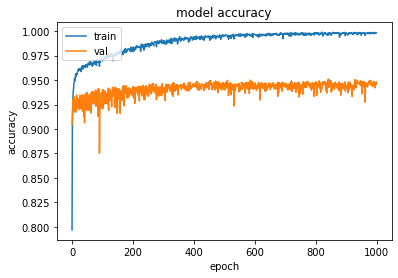

In [14]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()